In [1]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Specific for the HDDM study
import hddm

# Save/load datatables functions

In [3]:
# directory = the filepath to where you want to save your data.  
#   You could use directory="" to save it in the same directory 
#   you are running the notebook in.

# foldername = a name for a new folder to put this specific data set in.
#   The code will create this folder for you.  
#   Whenever you have a new data set, you need to use a new foldername, 
#   otherwise it will overwrite the older results.

def saveData(paramtable,datatables,directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable.to_pickle(file_name,protocol=0)
    for i in range(len(datatables)):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables[i].to_pickle(file_name,protocol=0)
        
def loadData(directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable = pd.read_pickle(file_name)
    filecount = len([f for f in os.listdir(targetfolder) 
                     if os.path.isfile(os.path.join(targetfolder, f)) 
                     and f.startswith("data") and f.endswith(".pkl")])
    datatables = []
    for i in range(filecount):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables.append(pd.read_pickle(file_name))
    return (paramtable,datatables)

# Global Parameters:

In [4]:
# Working directory
parentDir = 'dftest'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [5]:
BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [6]:
def get_sampling_params2(scale=.05, values=[0.063,0.063,0.063,0.063,
                                          0.1286,0.1286,0.1286,0.1286,
                                          0.28,1.1,0.28,1.65,0.4,0.012,
                                          0.0324,0.067,0.255,0.255,
                                          0.03,0.132,0.07,4.01,0.02]):
    
    Cx_dMSN_NMDA_L = values[0] #0.063
    Cx_dMSN_NMDA_R = values[1] #0.063
    Cx_iMSN_NMDA_L = values[2] #0.063
    Cx_iMSN_NMDA_R = values[3] #0.063
    
    Cx_dMSN_AMPA_L = values[4] #0.1286
    Cx_dMSN_AMPA_R = values[5] #0.1286
    Cx_iMSN_AMPA_L = values[6] #0.1286
    Cx_iMSN_AMPA_R = values[7] #0.1286
    
    dMSN_iMSN = values[8] #0.28
    D1STR_GPi = values[9] #1.10
    
    iMSN_dMSN  = values[10] #0.28
    D2STR_GPeP = values[11] #1.65
    
    GPe_STN = values[12] #0.4
    GPe_GPi = values[13] #0.012
    
    STN_GPi    = values[14] #0.0324
    
    GPi_Th     =  values[15] #0.067
    
    Th_STRd = values[16] #0.255
    Th_STRi = values[17] #0.255
    
    
    
    CxTh       =    values[18] #0.03
    CxFSI      =    values[19] #0.132
    STN_GPeP_A =    values[20] #0.07
    STN_GPeP_N =    values[21] #4.01
    ThCx       =    values[22] #0.02
    
    
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset

In [7]:
def get_sampling_params(scale=.05, values=[0.063,0.063,0.063,0.063,
                                          0.1286,0.1286,0.1286,0.1286,
                                          0.28,1.1,0.28,1.65,0.4,0.012,
                                          0.0324,0.067,0.255,0.255,
                                          0.03,0.132,0.07,4.01,0.02]):
    
    Cx_dMSN_NMDA_L = values[0,0] #0.063
    Cx_dMSN_NMDA_R = values[0,1] #0.063
    Cx_iMSN_NMDA_L = values[0,2] #0.063
    Cx_iMSN_NMDA_R = values[0,3] #0.063
    
    Cx_dMSN_AMPA_L = values[0,4] #0.1286
    Cx_dMSN_AMPA_R = values[0,5] #0.1286
    Cx_iMSN_AMPA_L = values[0,6] #0.1286
    Cx_iMSN_AMPA_R = values[0,7] #0.1286
    
    dMSN_iMSN = values[0,8] #0.28
    D1STR_GPi = values[0,9] #1.10
    
    iMSN_dMSN  = values[0,10] #0.28
    D2STR_GPeP = values[0,11] #1.65
    
    GPe_STN = values[0,12] #0.4
    GPe_GPi = values[0,13] #0.012
    
    STN_GPi    = values[0,14] #0.0324
    
    GPi_Th     =  values[0,15] #0.067
    
    Th_STRd = values[0,16] #0.255
    Th_STRi = values[0,17] #0.255
    
    
    
    CxTh       =    values[0,18] #0.03
    CxFSI      =    values[0,19] #0.132
    STN_GPeP_A =    values[0,20] #0.07
    STN_GPeP_N =    values[0,21] #4.01
    ThCx       =    values[0,22] #0.02
    
    
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STRd': X['Cx']['STRd'][idx], 
        'STRi': X['Cx']['STRi'][idx],
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx],
           'D2STR': X['D1STR']['D2STR'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx],
           'D1STR_syn': X['D2STR']['D1STR_syn'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STRd': X['Th']['STRd'][idx], 
        'STRi': X['Th']['STRi'][idx],
        'Cx': X['Th']['Cx'][idx]}
    
    GPeP={'STN': X['GPeP']['STN'][idx],
          'GPi': X['GPeP']['GPi'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th, GPeP=GPeP)

# Sampe N_subj individual networks and run the simulation.

In [7]:
# Sampe N_subj individual networks.
N_subj = 1
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff, preset = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

In [8]:
# Write simulation configuration files
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250
# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[55],
                               d2aw=[-45],
                               rewardprob=[1.0],
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7
                              )
sweepcount

1

In [ ]:
# Run 1 simulation
cores=4
ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)

In [19]:
# Create data-tables
# read in all population firing rates for all sims

results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
decisions = []
for sn in range(totalSim):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])

In [ ]:
#### read in detailed info for the first few sims

resultsB = ng.readAllTrialResults(1,0,1,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs']) 
decisionsB = []
for sn in range(1):
    decisionsB.append([])
    for result in resultsB[sn]:
        decisionsB[sn].append(ng.findOutputs2(result)['decision made'])

In [20]:
(paramtable,datatables) = gf.generateFrames(results,decisions)

# Latin Hypercube sampling

## (a) Latin Hypercube sampling Returning centered values

In [82]:
import pyDOE
from pyDOE import *
from smt.sampling_methods import LHS

xlimits = np.array([[0.01575, 0.252], [0.01575, 0.252], [0.01575, 0.252], [0.01575, 0.252],
                    [0.03215, 0.5144], [0.03215, 0.5144], [0.03215, 0.5144], [0.03215, 0.5144],
                    [0.07, 1.12], [0.275, 4.4], [0.07, 1.12], [0.4125, 6.6],
                    [0.1, 1.6], [0.003, 0.033], [0.016, 0.067], [0.01675, 0.138],
                    [0.06375, 1.02], [0.06375, 1.02], [0.016, 0.12], [0.033,0.528],
                    [0.0175, 0.28], [1.0025, 16.04], [0.005, 0.08]])
sampling = LHS(xlimits=xlimits,criterion='m')

num = 100
values = sampling(num)

print(values2.shape)

plt.plot(values[:, 0], values[:, 1], "o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

NameError: name 'values2' is not defined

In [66]:
xlimits[1,:]

array([0.01575, 0.252  ])

## (b) Latin Hypercube sampling Returning Uniformly distributed values

In [83]:
import lhsmdu
import matplotlib.pyplot as plt
import numpy

numVar=23
N=100
values4 = lhsmdu.sample(numVar,N) # Latin Hypercube Sampling of two variables, and 10 samples each.
#kprova = lhsmdu.createRandomStandardUniformMatrix(numVar,N) # Monte Carlo Sampling

for i in range(0,numVar):
    xmin=xlimits[i,0]
    xmax=xlimits[i,1]
    values4[i,:]=(xmax-xmin)*values4[i,:]+xmin
values4=np.transpose(values4)

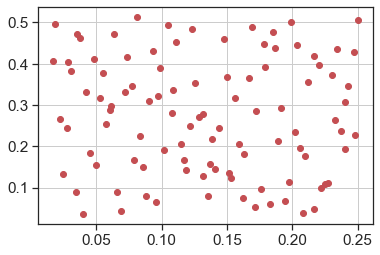

In [85]:
fig = plt.figure()
ax = fig.gca()
#plt.plot(kprova[0, :], kprova[1, :], "o", color="b")
plt.plot(values4[:, 0], values4[:, 4], "o", color="r")
plt.grid()
plt.show()

In [247]:
values3[70:72,:]

matrix([[ 0.20776473,  0.11104547,  0.05356973,  0.20235658,  0.03743057,
          0.21764158,  0.14965046,  0.19574866,  0.20702651,  0.59285198,
          0.46865685,  2.14944309,  0.65076555,  0.01491382,  0.03257667,
          0.08513953,  0.2314009 ,  0.79210547,  0.05016684,  0.12781949,
          0.15963124, 10.20004251,  0.06317616],
        [ 0.22706061,  0.05861632,  0.16484821,  0.19151538,  0.11085689,
          0.23187421,  0.13766349,  0.09039458,  0.09516439,  0.8393088 ,
          1.09701978,  2.52208333,  1.09916958,  0.0104646 ,  0.03330237,
          0.05295814,  1.00502739,  0.88925022,  0.11713703,  0.24879991,
          0.25645317,  9.12665389,  0.02736066]])

# Phenotypes Study

## (a) Phenotypes - find boundaries (connections 1 by 1)

In [244]:
import statistics
NumSteps=1  #number of steps
eps=1e-3    #discretization size

N_subj = 1
sdScale = .0 # variablity on the efficacy values.
conProb = ng.getConProb()

cores=4
np.random.seed(seed=np.random.randint(0,1000))

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250

for ns in range(0,NumSteps):
#    value= 0.02/4.0
#    value=  0.15+ns*eps     # to move according eps.
#    value= 0.07*(0.25+0.375*ns)     #to move from 1/4 to 4 times the usual value
    value= [4.20956264e-02, 1.74556779e-01, 1.58222939e-01, 2.16413128e-01, 3.30472765e-01, 1.47288775e-01, 2.81382287e-01, 4.19834394e-01, 1.93384748e-01, 1.15566472e+00, 6.61621336e-01, 6.27535423e+00, 1.45629085e+00, 4.33050358e-03, 4.03313964e-02, 9.99582946e-02, 9.50520963e-01, 1.43282018e-01, 2.49098511e-02, 2.70732514e-01, 1.37674385e-01, 3.64286187e+00, 7.47032616e-02]

    varIter=75
    print('Step',ns,' with value', value)
    
    # define parameters
    muEff, sdEff, preset = get_sampling_params2(sdScale,value)
    X = sample_network_efficacies(muEff, sdEff, N=N_subj)
    subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
    
    # get conn. efficacies for 1st subject network (idx=0)
    idx = 0
    conEff_i = subj_eff_dicts[idx]

    # configure trial and network parameters
    sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[0], # Changes the alpha_w for D1
                               d2aw=[0], # Changes the alpha_w for D2
                               rewardprob=[1.0], # It's overwritten inside the netgen.
                               dpmn_ratio=0.,   # it doesn't do anything
                               dpmn_implied=0.  # it doesn't do anything
                              )
    sweepcount
    
    # run the simulation
    ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)
    
    results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
    decisions = []
    for sn in range(totalSim):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs2(result)['decision made'])
    
    # Change the None values in decisions' list for 0's
    for xdec in decisions[0][0]:
        if xdec['delay']==None:
            xdec['delay']=0.0
    
    (paramtable,datatables) = gf.generateFrames(results,decisions)
    foldername="Uniform_ResultsCase"+str(varIter)
    saveData(paramtable,datatables,"",foldername)
    
    
#    dd=datatables[0].decisionduration[0:50]
#    d1=datatables[0].decision[0:50]
    # REMOVE 'None' values from d
#    d=[]
#    for val in d1: 
#        if val != None: 
#            d.append(val) 
#    dratio=(sum(d)/len(d))*100  # d contains 0=action is given; 1=action is NON given
#    if max(dd) >= 300: # to be correct, the action decision time must be smaller than 150ms
#        print('The value', value, 'causes a reaction time greater than the expected')
#    if min(dd) <= 75: # to be correct, the action decision time must be greater than 75ms
#        print('The value', value, 'causes a reaction time smaller than the expected')
#    print(value, '&', min(dd), '&', max(dd),'&', statistics.mean(dd), '&', dratio, '\% \\'#)

Step 0  with value [0.0420956264, 0.174556779, 0.158222939, 0.216413128, 0.330472765, 0.147288775, 0.281382287, 0.419834394, 0.193384748, 1.15566472, 0.661621336, 6.27535423, 1.45629085, 0.00433050358, 0.0403313964, 0.0999582946, 0.950520963, 0.143282018, 0.0249098511, 0.270732514, 0.137674385, 3.64286187, 0.0747032616]
Waiting for subprocess to end
Done


## (b) Phenotypes - changing all connections

In [86]:
import statistics

N_subj = 1
sdScale = .0 # variablity on the efficacy values.
conProb = ng.getConProb()

# number of different phenotypes to explore. 
# It must be = or less than variable num in LHS function
NumSteps=100

cores=4
np.random.seed(seed=np.random.randint(0,1000))

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250

#NumSteps
for ns in range(0,NumSteps):
    valuesUsed=values4[ns,:]
    print('Step', ns, 'Values considered', valuesUsed)
    
    # define parameters
    muEff, sdEff, preset = get_sampling_params(sdScale,valuesUsed)
    X = sample_network_efficacies(muEff, sdEff, N=N_subj)
    subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
    
    # get conn. efficacies for 1st subject network (idx=0)
    idx = 0
    conEff_i = subj_eff_dicts[idx]

    # configure trial and network parameters
    sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[0], # Changes the alpha_w for D1
                               d2aw=[0], # Changes the alpha_w for D2
                               rewardprob=[1.0], # It's overwritten inside the netgen.
                               dpmn_ratio=0.,   # it doesn't do anything
                               dpmn_implied=0.  # it doesn't do anything
                              )
    sweepcount
    
    # run the simulation
    ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)
    
    results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
    decisions = []
    for sn in range(totalSim):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs2(result)['decision made'])

    # Change the None values in decisions' list for 0's
    for xdec in decisions[0][0]:
        if xdec['delay']==None:
            xdec['delay']=0.0

    (paramtable,datatables) = gf.generateFrames(results,decisions)
    foldername="Uniform_ResultsCase"+str(ns+200)
    saveData(paramtable,datatables,"",foldername)

Step 0 Values considered [[ 0.10861599  0.14895966  0.24522418  0.21225598  0.33628118  0.44039539
   0.1112721   0.23139395  0.99341435  3.68817914  0.12047051  4.88466263
   1.56232362  0.01786762  0.05674201  0.08704386  0.8785211   0.1976709
   0.09973747  0.26559094  0.02859322 13.96282486  0.0559595 ]]
Waiting for subprocess to end
Done
Step 1 Values considered [[0.23991462 0.19255117 0.14449564 0.02369657 0.30691132 0.45209346
  0.32276338 0.03597184 0.34918981 0.29678241 0.99417366 6.50569585
  0.47888333 0.01681741 0.01970846 0.07133332 0.56388238 0.2789934
  0.10046199 0.16991123 0.16359808 8.09995951 0.04603393]]
Waiting for subprocess to end
Done
Step 2 Values considered [[9.05851022e-02 2.50817687e-02 1.36489388e-01 1.96182309e-01
  3.10317455e-01 7.18986355e-02 4.90188401e-01 1.72631612e-01
  7.24617269e-01 3.50946313e+00 2.18961483e-01 6.44350329e+00
  8.31317850e-01 5.60887904e-03 5.01898759e-02 7.00365276e-02
  5.72483326e-01 6.90624647e-01 2.90378867e-02 4.40708760e-0

Waiting for subprocess to end
Done
Step 24 Values considered [[0.19901004 0.1790355  0.02654528 0.12635732 0.50136008 0.28986195
  0.4002396  0.50371707 1.06961023 4.01551028 1.01516978 4.20604217
  1.22047349 0.02217998 0.01825857 0.12775309 0.43769098 0.90944566
  0.1050855  0.28480531 0.23421548 7.38651017 0.06946042]]
Waiting for subprocess to end
Done
Step 25 Values considered [[ 0.02462468  0.0537186   0.16319479  0.04714876  0.13279988  0.06619901
   0.25361436  0.4829838   0.18329578  2.49557931  0.93721252  0.48924498
   1.59889283  0.02135871  0.05749277  0.07252926  0.15958869  0.47717585
   0.0774126   0.16564471  0.25338608 15.34946828  0.03271562]]
Waiting for subprocess to end
Done
Step 26 Values considered [[0.03727374 0.12149682 0.15086735 0.05671508 0.4613724  0.37333761
  0.13954397 0.47743784 0.81322888 1.77892419 0.14363291 1.98157337
  0.2321718  0.02962937 0.03101467 0.10894852 0.78257759 0.42150094
  0.09659303 0.11886515 0.13518173 6.03964829 0.06574285]]
Waiti

Waiting for subprocess to end
Done
Step 48 Values considered [[0.15170763 0.16698907 0.0635766  0.2338424  0.1360708  0.0456938
  0.11475655 0.44307243 0.53267447 1.91241732 0.62275078 3.92040382
  0.26763423 0.02882517 0.05929108 0.07613986 0.63478282 0.11711603
  0.04556795 0.25986561 0.23238082 7.99790628 0.06629756]]
Waiting for subprocess to end
Done
Step 49 Values considered [[0.11486438 0.24919995 0.07980751 0.10782496 0.20441864 0.36567381
  0.50596865 0.51425569 0.48153757 4.12397128 0.17354187 4.5529922
  0.72057844 0.027455   0.04868354 0.09012846 0.85516134 0.70906269
  0.07372177 0.34083255 0.10701663 1.5561502  0.02390969]]
Waiting for subprocess to end
Done
Step 50 Values considered [[1.62650935e-01 5.67610944e-02 1.28047511e-01 7.07677529e-02
  1.81615540e-01 3.99999517e-01 9.69140006e-02 4.16348256e-01
  5.80889572e-01 2.37367042e+00 9.61074713e-02 1.30316618e+00
  8.80424274e-01 5.76751750e-03 2.03066350e-02 4.21247614e-02
  2.47950662e-01 4.72344477e-01 4.39772367e-0

Waiting for subprocess to end
Done
Step 72 Values considered [[ 0.14116812  0.1155254   0.14861579  0.20553413  0.14493456  0.38973401
   0.46154175  0.14272996  1.03988504  3.09205875  0.4386521   4.71794004
   0.91267799  0.03101135  0.03681565  0.05819454  0.23957888  0.07496157
   0.08257827  0.24214019  0.2562005  11.54228158  0.03182619]]
Waiting for subprocess to end
Done
Step 73 Values considered [[ 0.06603973  0.24232672  0.24307264  0.1471627   0.08819996  0.24413658
   0.33108705  0.37795767  1.1019904   0.65987533  0.3022784   0.6013216
   1.26064221  0.01592261  0.02687483  0.13623489  0.60729868  0.90143751
   0.06968398  0.14355252  0.05825772 14.42896457  0.04085224]]
Waiting for subprocess to end
Done
Step 74 Values considered [[0.07193377 0.15286216 0.06296881 0.1830755  0.33190759 0.4922373
  0.29094645 0.08196504 0.83557342 2.24186247 0.25474198 3.40334735
  0.15201757 0.0323875  0.04251095 0.02396504 0.09453521 0.8738103
  0.11111623 0.12443269 0.27616182 1.9005785

Waiting for subprocess to end
Done
Step 95 Values considered [[0.15938288 0.2504286  0.09104767 0.13221136 0.2057824  0.50565445
  0.25615358 0.12325295 0.46228124 2.58467708 0.6058303  5.21493266
  0.12928631 0.02493208 0.01953952 0.04463465 0.69344039 0.26666562
  0.07442368 0.06456063 0.16820361 4.92513175 0.0753891 ]]
Waiting for subprocess to end
Done
Step 96 Values considered [[0.08075414 0.03102183 0.12023166 0.04898335 0.51379077 0.44291709
  0.49899541 0.06827568 0.5698013  1.00329325 0.21380249 5.80495531
  1.14735696 0.01634814 0.04644338 0.13092399 0.80002416 0.40772478
  0.11953067 0.08214227 0.0530819  4.75388518 0.02597366]]
Waiting for subprocess to end
Done
Step 97 Values considered [[0.24994636 0.15732795 0.04050143 0.08874114 0.50623708 0.31606521
  0.30298939 0.48835452 0.73314074 1.61736148 0.4736035  4.60984935
  0.39221577 0.0293622  0.05571249 0.06774111 0.21204675 0.07070425
  0.04770031 0.50371756 0.04176407 6.30949298 0.06393604]]
Waiting for subprocess to en

In [64]:
foldername="Uniform_ResultsCase1"
(paramtable,datatables) = loadData("",foldername)
datatables2=datatables[0].loc[datatables[0]['decision']!=None]

In [62]:
#import statistics
#dtaux=statistics.mean(datatables2.decision)
dtaux=datatables2.mean()
di=dtaux.to_dict()

# FR general datatable

In [9]:
NumSteps=200
FRdatatable=[]
for ns in range(0,NumSteps):
#    if ns not in [11,43,75]:
    foldername="Uniform_ResultsCase"+str(ns)
    (paramtable,datatables) = loadData("",foldername)
    
    datatables2=datatables[0].loc[datatables[0]['decision']!=None]
    dtaux=datatables2.mean()
    di=dtaux.to_dict()

    FRdatatable.append(di)

FRdatatable=pd.DataFrame(FRdatatable)
targetfolder = os.path.join("","MeanSolution")
file_name = os.path.join(targetfolder,"MeanSol.pkl")
if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
FRdatatable.to_pickle(file_name)

In [42]:
# load HDDM data
targetfolder = os.path.join("","MeanSolution")
file_name = os.path.join(targetfolder,"MeanSol.pkl")
FRdatatable = pd.read_pickle(file_name)

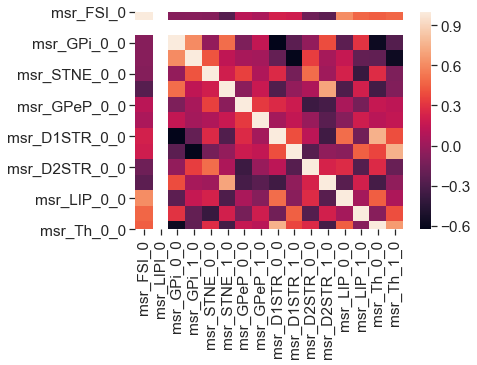

In [33]:
#list(FRdatatable.columns.values)
import seaborn as sn
#dfaux = pd.DataFrame(FRdatatable,columns=['msr_FSI_0','msr_LIPI_0','msr_GPi_0_0','msr_GPi_1_0','msr_STNE_0_0','msr_STNE_1_0','msr_GPeP_0_0','msr_GPeP_1_0','msr_D1STR_0_0','msr_D1STR_1_0','msr_D2STR_0_0','msr_D2STR_1_0','msr_LIP_0_0','msr_LIP_1_0','msr_Th_0_0','msr_Th_1_0'])
dfaux = pd.DataFrame(FRdatatable,columns=['msr_FSI_0','msr_LIPI_0','msr_GPi_0_0','msr_GPi_1_0','msr_STNE_0_0','msr_STNE_1_0','msr_GPeP_0_0','msr_GPeP_1_0','msr_D1STR_0_0','msr_D1STR_1_0','msr_D2STR_0_0','msr_D2STR_1_0','msr_LIP_0_0','msr_LIP_1_0','msr_Th_0_0','msr_Th_1_0'])
corrMatrix = dfaux.corr(method='pearson')
#print (corrMatrix)
fig = plt.figure()
sn.heatmap(corrMatrix, annot=False)
plt.show()
fig.savefig('corr_generalSol.png', dpi=400)

# HDDM study

In [142]:
def fitHDDM(datatables):
    hddm_inputs = []
    hddm_models = []
    hddm_stats = []
    hddm_dbs = []
    for sourcetable in datatables:
        all_obs_data = pd.DataFrame()
        all_obs_data['response'] = sourcetable['decision']
        all_obs_data['rt'] = sourcetable['decisiondurationplusdelay']/1000.0
        all_obs_data['reward_code'] = sourcetable['reward']
        all_obs_data.dropna(inplace=True)  # new line
        model = hddm.HDDM(all_obs_data,bias=True)#  include=('z'), depends_on={'v':['reward_code']})
        model.find_starting_values()
        n_samples = 3000
        n_burn = 500
        n_effective_samples = n_samples - n_burn
        model_db = "basicmodel" + str(len(hddm_stats)) + ".db"
        model.sample(n_samples, burn = n_burn, dbname = model_db, db='pickle')
        stats = model.gen_stats()
        
        hddm_inputs.append(all_obs_data)
        hddm_models.append(model)
        hddm_stats.append(stats)
        hddm_dbs.append(model_db)
    return (hddm_inputs, hddm_models, hddm_stats, hddm_dbs)

In [143]:
foldername="Uniform_ResultsCase1"
(paramtable,datatables) = loadData("",foldername)
    
datatables2=datatables[0].loc[datatables[0]['decision']!=None]
#datatables3=datatables2.loc[datatables2['decisiondurationplusdelay']>=420]
#datatables4=datatables3.loc[datatables3['decisiondurationplusdelay']<=433]
#reactTime=datatables2.decisiondurationplusdelay/1000.0
#suma=0
#for x in reactTime:
#    if x<=100:
#        suma=suma+1
#suma
#reactTime
## Plot the RT histograms
# fig = plt.figure()
# plt.hist(reactTime,20)
# fig.savefig('hist_RTRight_Case0.png', dpi=400)
(hddm_inputs, hddm_models, hddm_stats, hddm_dbs) = fitHDDM([datatables2])

1615.09689853


AttributeError: Deterministic z's value cannot be set.

In [125]:
hddm_stats

[          mean          std      2.5q       25q       50q       75q     97.5q  \
 a     0.983154    0.0668625  0.863377   0.93422  0.981099   1.02857   1.12178   
 v(0)  -24.6362     0.965309  -26.5484   -25.261  -24.6275  -23.9504  -22.8078   
 v(1)  -17.4372      1.56765  -20.4287  -18.4614  -17.4806  -16.3496  -14.3234   
 t     0.381023  0.000797104  0.379409  0.380488  0.381047  0.381592  0.382474   
 
            mc err  
 a      0.00568335  
 v(0)    0.0713132  
 v(1)    0.0736191  
 t     6.40169e-05  ]

In [9]:
## hddm study - create a datatable with the HDDM results of each simulation
import statistics

NumSteps=300
hddm_results=[]
for ns in range(0,NumSteps):
#    if ns not in [11,43,75]:
    foldername="Uniform_ResultsCase"+str(ns)
    (paramtable,datatables) = loadData("",foldername)
    
    datatables2=datatables[0].loc[datatables[0]['decision']!=None]
    (hddm_inputs, hddm_models, hddm_stats, hddm_dbs) = fitHDDM([datatables2])
        
    di=dict()
    di['trial']=ns
    di['mean_a']=hddm_stats[0]['mean']['a']
    di['std_a']=hddm_stats[0]['std']['a']
    di['mean_v']=hddm_stats[0]['mean']['v']
    di['std_v']=hddm_stats[0]['std']['v']
    di['mean_t']=hddm_stats[0]['mean']['t']
    di['std_t']=hddm_stats[0]['std']['t']
    L=float(sum(hddm_inputs[0]['reward_code']))
    LR=float(len(hddm_inputs[0]['reward_code']))
    di['perc_L']=L/LR*100
    di['perc_R']=(1-L/LR)*100
    di['rt']=statistics.mean(datatables[0].decisionduration) #reaction time
    
    hddm_results.append(di)
        #av.append(hddm_stats[0]['mean']['a'])
        #vv.append(hddm_stats[0]['mean']['v'])
        #tv.append(hddm_stats[0]['mean']['t'])

hddm_datatable=pd.DataFrame(hddm_results)
targetfolder = os.path.join("","hddmSolution-300")
file_name = os.path.join(targetfolder,"hddmSol-300.pkl")
if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
hddm_datatable.to_pickle(file_name)
#file_name = os.path.join(targetfolder,"dataHddm.pkl")
#hddm_inputs.to_pickle(file_name)

576.329942632


AttributeError: Deterministic z's value cannot be set.

# PLOT RESULTS

In [8]:
# load FR data
targetfolder = os.path.join("","MeanSolution-300")
file_name = os.path.join(targetfolder,"MeanSol-300.pkl")
FRdatatable = pd.read_pickle(file_name)

In [9]:
# load HDDM data
targetfolder = os.path.join("","hddmSolution-300")
file_name = os.path.join(targetfolder,"hddmSol-300.pkl")
hddmSol = pd.read_pickle(file_name)

In [10]:
def find_minors(l,valor):
    cont=0
    minors=[]
    for x in l:
        if x<=valor:
            minors.append(cont)
        cont+=1
    return minors           

In [11]:
PosMinors=find_minors(hddmSol.mean_a,4)

## (1) HDDM scatter plots 

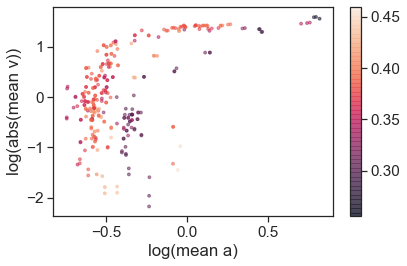

In [12]:
# Scatter plot for te HDDM results: a-v (with colormap = t) 

# x and y are the variables we would like to plot in each axis.
# s = point size
# c = list of colors; Ex. c = np.random.rand(N)

fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v]
xx=[math.log(abs(x),10) for x in hddmSol.mean_a]
plt.scatter(xx, yy, s=8, c=hddmSol.mean_t, alpha=0.5)
# plt.scatter(hddmSol.mean_a[PosMinors], abs(hddmSol.mean_v[PosMinors]), s=4, c=hddmSol.mean_t[PosMinors], alpha=0.5)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogvt2-abs.png', dpi=400)

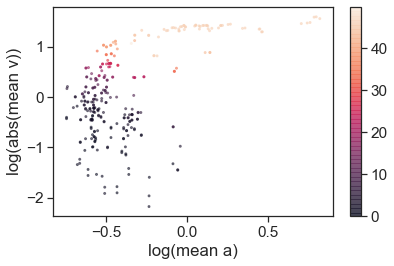

In [29]:
# Scatter plot for te HDDM results: a-v (with colormap = perc_L) 
import math
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v]
xx=[math.log(abs(x),10) for x in hddmSol.mean_a]
plt.scatter(xx, yy, s=8, c=abs(hddmSol.perc_L-50), alpha=0.5)
# plt.scatter(hddmSol.mean_a[PosMinors], hddmSol.mean_v[PosMinors], s=4, c=hddmSol.perc_L[PosMinors], alpha=0.5)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_percLeft50-abs.png', dpi=400)

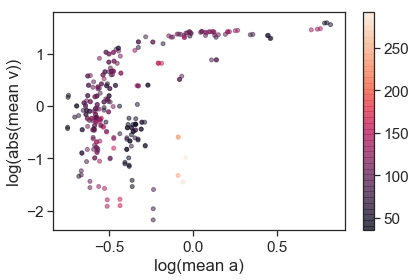

In [141]:
# Scatter plot for te HDDM results: a-v (with colormap = rt) 
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v] #abs(hddmSol.mean_v)
xx=[math.log(abs(x),10) for x in hddmSol.mean_a] #hddmSol.mean_a
plt.scatter(xx, yy, s=16, c=hddmSol.rt, alpha=0.5)
# plt.scatter(hddmSol.mean_a[PosMinors], hddmSol.mean_v[PosMinors], s=4, c=hddmSol.rt[PosMinors], alpha=0.5)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_ReactionTime2-abs.png', dpi=400)

## (2) HDDM Pearson Correlation

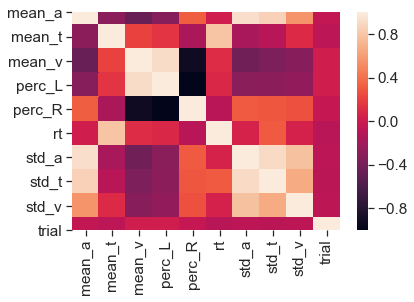

In [36]:
import seaborn as sn
corrMatrix = hddmSol.corr(method='pearson')
#print (corrMatrix)
fig = plt.figure()
sn.heatmap(corrMatrix, annot=False)
plt.show()
fig.savefig('corr_hddmSol.png', dpi=400)

                 rt  abs_percL
rt         1.000000   0.092267
abs_percL  0.092267   1.000000


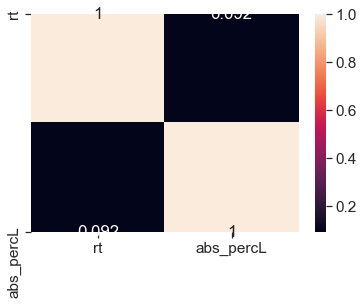

In [39]:
import seaborn as sn
df=dict()
df['rt']=hddmSol.rt
df['abs_percL']=abs(hddmSol.perc_L-50)
df=pd.DataFrame(df)
corrMatrix = df.corr(method='pearson')
print (corrMatrix)
fig = plt.figure()
sn.heatmap(corrMatrix, annot=True)
plt.show()
#fig.savefig('corr_rt.png', dpi=400)

## (3) Pearson correlations between FR and HDDM parameters

In [54]:
import seaborn as sn
# Select the columns we want from FRdatatable
#dfFR = pd.DataFrame(FRdatatable,columns=['msr_FSI_0','msr_LIPI_0','msr_GPi_0_0','msr_GPi_1_0','msr_STNE_0_0','msr_STNE_1_0','msr_GPeP_0_0','msr_GPeP_1_0','msr_D1STR_0_0','msr_D1STR_1_0','msr_D2STR_0_0','msr_D2STR_1_0','msr_LIP_0_0','msr_LIP_1_0','msr_Th_0_0','msr_Th_1_0'])
#dfFR = pd.DataFrame(FRdatatable,columns=['isr_FSI_0','isr_LIPI_0','isr_GPi_0_0','isr_GPi_1_0','isr_STNE_0_0','isr_STNE_1_0','isr_GPeP_0_0','isr_GPeP_1_0','isr_D1STR_0_0','isr_D1STR_1_0','isr_D2STR_0_0','isr_D2STR_1_0','isr_LIP_0_0','isr_LIP_1_0','isr_Th_0_0','isr_Th_1_0'])

dfFR = pd.DataFrame(FRdatatable,columns=['msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0'])
#dfFR = pd.DataFrame(FRdatatable,columns=['msd_FSI_0','msd_LIPI_0','msd_GPi_0_0','msd_GPi_1_0','msd_STNE_0_0','msd_STNE_1_0','msd_GPeP_0_0','msd_GPeP_1_0','msd_D1STR_0_0','msd_D1STR_1_0','msd_D2STR_0_0','msd_D2STR_1_0','msd_LIP_0_0','msd_LIP_1_0','msd_Th_0_0','msd_Th_1_0'])
#dfFR = pd.DataFrame(FRdatatable,columns=['isd_FSI_0','isd_LIPI_0','isd_GPi_0_0','isd_GPi_1_0','isd_STNE_0_0','isd_STNE_1_0','isd_GPeP_0_0','isd_GPeP_1_0','isd_D1STR_0_0','isd_D1STR_1_0','isd_D2STR_0_0','isd_D2STR_1_0','isd_LIP_0_0','isd_LIP_1_0','isd_Th_0_0','isd_Th_1_0'])

#dfFR = pd.DataFrame(FRdatatable,columns=['mdr_FSI_0','mdr_LIPI_0','mdr_GPi_0_0','mdr_GPi_1_0','mdr_STNE_0_0','mdr_STNE_1_0','mdr_GPeP_0_0','mdr_GPeP_1_0','mdr_D1STR_0_0','mdr_D1STR_1_0','mdr_D2STR_0_0','mdr_D2STR_1_0','mdr_LIP_0_0','mdr_LIP_1_0','mdr_Th_0_0','mdr_Th_1_0'])
#dfFR = pd.DataFrame(FRdatatable,columns=['idr_FSI_0','idr_LIPI_0','idr_GPi_0_0','idr_GPi_1_0','idr_STNE_0_0','idr_STNE_1_0','idr_GPeP_0_0','idr_GPeP_1_0','idr_D1STR_0_0','idr_D1STR_1_0','idr_D2STR_0_0','idr_D2STR_1_0','idr_LIP_0_0','idr_LIP_1_0','idr_Th_0_0','idr_Th_1_0'])


# Select the columns we want from hddmSol
dfHDDM = pd.DataFrame(hddmSol,columns=['mean_a','mean_v','rt'])

diFR=dfFR.to_dict()
diHDDM=dfHDDM.to_dict()
diFR['mean_a']=diHDDM['mean_a']
diFR['mean_v']=diHDDM['mean_v']
diFR['rt']=diHDDM['rt']
dtFRandHDDM=pd.DataFrame(diFR)
#dtFRandHDDM

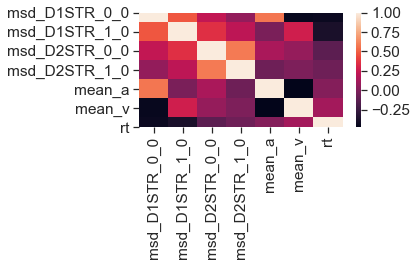

In [55]:
corrMatrix = dtFRandHDDM.corr(method='pearson')
#print (corrMatrix)
fig = plt.figure()
sn.heatmap(corrMatrix, annot=False)
plt.tight_layout()
plt.show()
#fig.savefig('corr_FRmsr.png', dpi=400)
#fig.savefig('corr_FRisr.png', dpi=400)

fig.savefig('corr_FRmsd-STR-300.png', dpi=400)
#fig.savefig('corr_FRisd.png', dpi=400)

#fig.savefig('corr_FRmdr.png', dpi=400)
#fig.savefig('corr_FRidr.png', dpi=400)

## (4) Firing Rates with HDDM outputs scatter plots

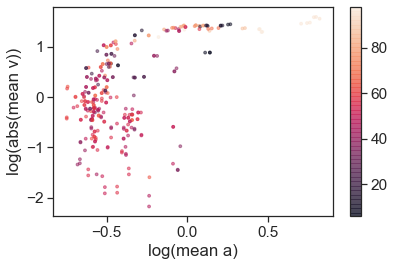

In [19]:
# Scatter plot for te HDDM results: a-v (with colormap = Firing Rates) 
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v] #abs(hddmSol.mean_v)
xx=[math.log(abs(x),10) for x in hddmSol.mean_a] #hddmSol.mean_a
#cm = plt.cm.get_cmap('tab10')#'RdYlBu', tab10, RdPu, nipy_spectral
cbar=abs(FRdatatable.msd_D1STR_0_0-FRdatatable.msd_D1STR_1_0)/abs(FRdatatable.msd_D1STR_0_0+FRdatatable.msd_D1STR_1_0)
#cbar=FRdatatable.msd_D1STR_0_0/(FRdatatable.msd_D1STR_1_0+FRdatatable.msd_D1STR_0_0)*100
plt.scatter(xx, yy, s=8, c=cbar, alpha=0.5)#, cmap=cm)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_Ld1Rd1Div.png', dpi=400)

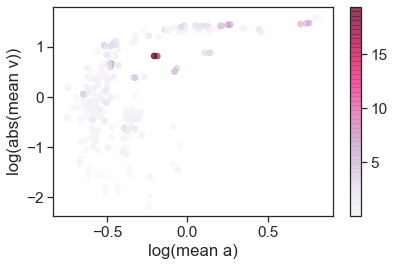

In [54]:
# Scatter plot for te HDDM results: a-v (with colormap = Firing Rates) 
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v] #abs(hddmSol.mean_v)
xx=[math.log(abs(x),10) for x in hddmSol.mean_a] #hddmSol.mean_a
cm = plt.cm.get_cmap('PuRd')#'RdYlBu', tab10, RdPu, nipy_spectral
cbar=abs(FRdatatable.msd_D2STR_0_0-FRdatatable.msd_D2STR_1_0)
#cbar=FRdatatable.msd_D2STR_0_0/(FRdatatable.msd_D2STR_1_0+FRdatatable.msd_D2STR_0_0)*100
plt.scatter(xx, yy, s=32, c=cbar, alpha=0.5, cmap=cm)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_Ld2Rd2absMinus_s32cPuRd.png', dpi=400)

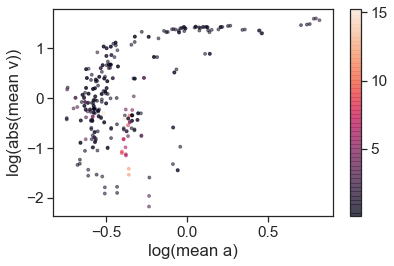

In [41]:
# Scatter plot for te HDDM results: a-v (with colormap = Firing Rates) 
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v] #abs(hddmSol.mean_v)
xx=[math.log(abs(x),10) for x in hddmSol.mean_a] #hddmSol.mean_a

cbar=[]
for ipos in range(0,300):
    if hddmSol.mean_v[ipos]>=0:
        caux=FRdatatable.msd_D1STR_0_0[ipos]/FRdatatable.msd_D2STR_0_0[ipos]
    if hddmSol.mean_v[ipos]<0:
        caux=FRdatatable.msd_D1STR_1_0[ipos]/FRdatatable.msd_D2STR_1_0[ipos]
    cbar.append(caux)
#cbar=FRdatatable.msd_D1STR_0_0/FRdatatable.msd_D2STR_0_0
#cbar=FRdatatable.msd_D1STR_0_0/(FRdatatable.msd_D1STR_0_0+FRdatatable.msd_D2STR_0_0)*100
plt.scatter(xx, yy, s=8, c=cbar, alpha=0.5)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_Ld1Ld2if.png', dpi=400)

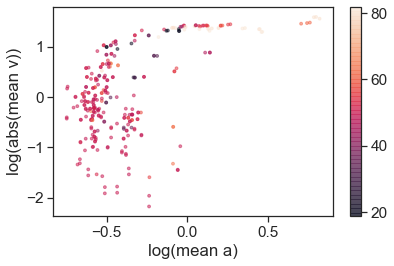

In [47]:
# Scatter plot for te HDDM results: a-v (with colormap = Firing Rates) 
fig = plt.figure()
yy=[math.log(abs(x),10) for x in hddmSol.mean_v] #abs(hddmSol.mean_v)
xx=[math.log(abs(x),10) for x in hddmSol.mean_a] #hddmSol.mean_a
#cm = plt.cm.get_cmap('tab10')#'RdYlBu', tab10, RdPu, nipy_spectral
#cbar=abs(FRdatatable.msd_STNE_0_0-FRdatatable.msd_STNE_1_0)/abs(FRdatatable.msd_STNE_0_0+FRdatatable.msd_STNE_1_0)
cbar=FRdatatable.msd_STNE_0_0/(FRdatatable.msd_STNE_0_0+FRdatatable.msd_STNE_1_0)*100
plt.scatter(xx, yy, s=8, c=cbar, alpha=0.5)#,cmap=cm)
plt.colorbar()
plt.xlabel("log(mean a)")
plt.ylabel("log(abs(mean v))")
plt.tight_layout()
plt.show()
fig.savefig('logalogv_LstnRstnDiv.png', dpi=400)

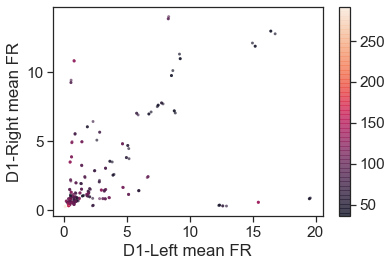

In [59]:
# Scatter plot for D1 and RT
fig = plt.figure()
xx=FRdatatable.msd_D1STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D1STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.rt, alpha=0.5)
plt.colorbar()
plt.xlabel("D1-Left mean FR")
plt.ylabel("D1-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D1-RT.png', dpi=400)

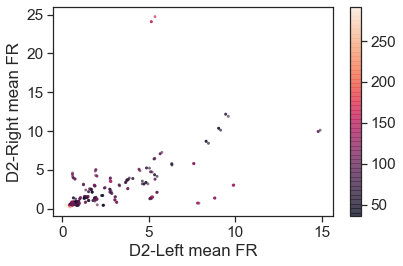

In [60]:
# Scatter plot for D2 and RT
fig = plt.figure()
xx=FRdatatable.msd_D2STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D2STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.rt, alpha=0.5)
plt.colorbar()
plt.xlabel("D2-Left mean FR")
plt.ylabel("D2-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D2-RT.png', dpi=400)

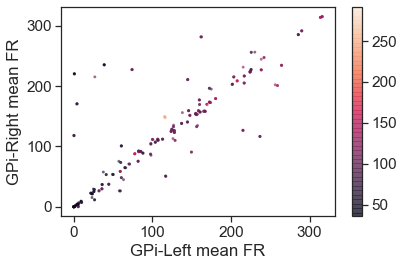

In [63]:
# Scatter plot for GPi and RT
fig = plt.figure()
xx=FRdatatable.msd_GPi_0_0 # msd D1STR left
yy=FRdatatable.msd_GPi_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.rt, alpha=0.5)
plt.colorbar()
plt.xlabel("GPi-Left mean FR")
plt.ylabel("GPi-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('GPi-RT.png', dpi=400)

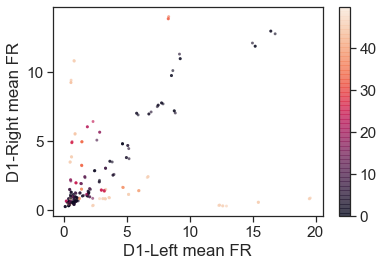

In [64]:
# Scatter plot for D1 and % Left
fig = plt.figure()
xx=FRdatatable.msd_D1STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D1STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=abs(hddmSol.perc_L-50), alpha=0.5)
plt.colorbar()
plt.xlabel("D1-Left mean FR")
plt.ylabel("D1-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D1-LeftPerc.png', dpi=400)

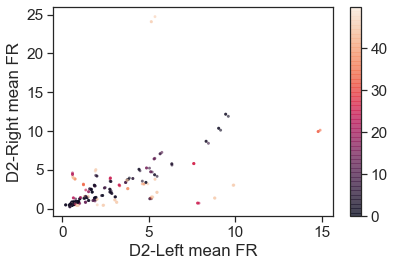

In [65]:
# Scatter plot for D2 and % Left
fig = plt.figure()
xx=FRdatatable.msd_D2STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D2STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=abs(hddmSol.perc_L-50), alpha=0.5)
plt.colorbar()
plt.xlabel("D2-Left mean FR")
plt.ylabel("D2-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D2-LeftPerc.png', dpi=400)

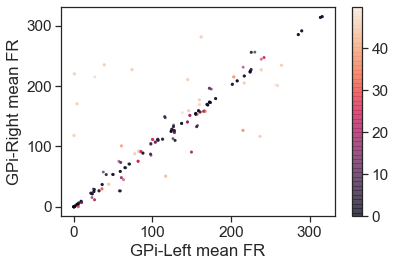

In [66]:
# Scatter plot for GPi and % Left
fig = plt.figure()
xx=FRdatatable.msd_GPi_0_0 # msd D1STR left
yy=FRdatatable.msd_GPi_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=abs(hddmSol.perc_L-50), alpha=0.5)
plt.colorbar()
plt.xlabel("GPi-Left mean FR")
plt.ylabel("GPi-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('GPi-LeftPerc.png', dpi=400)

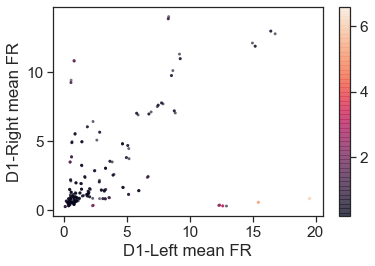

In [68]:
# Scatter plot for D1 and accuracy
fig = plt.figure()
xx=FRdatatable.msd_D1STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D1STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.mean_a, alpha=0.5)
plt.colorbar()
plt.xlabel("D1-Left mean FR")
plt.ylabel("D1-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D1-a.png', dpi=400)

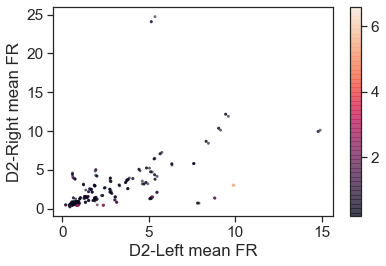

In [69]:
# Scatter plot for D2 and accuracy
fig = plt.figure()
xx=FRdatatable.msd_D2STR_0_0 # msd D1STR left
yy=FRdatatable.msd_D2STR_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.mean_a, alpha=0.5)
plt.colorbar()
plt.xlabel("D2-Left mean FR")
plt.ylabel("D2-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('D2-a.png', dpi=400)

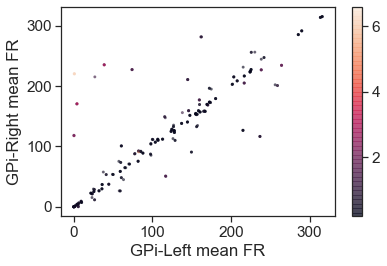

In [70]:
# Scatter plot for D1 and accuracy
fig = plt.figure()
xx=FRdatatable.msd_GPi_0_0 # msd D1STR left
yy=FRdatatable.msd_GPi_1_0 # msd D1STR right
plt.scatter(xx, yy, s=4, c=hddmSol.mean_a, alpha=0.5)
plt.colorbar()
plt.xlabel("GPi-Left mean FR")
plt.ylabel("GPi-Right mean FR")
plt.tight_layout()
plt.show()
fig.savefig('GPi-a.png', dpi=400)

# CCA correlations

In [128]:
import rcca
nComponents = 4
cca = rcca.CCA(kernelcca = False,
       reg = 0., numCC = nComponents)
cca.train([FRdatatable.msd_GPi_0_0, FRdatatable.msd_GPi_1_0])

ModuleNotFoundError: No module named 'rcca'

In [81]:
from sklearn.cross_decomposition import CCA
import scipy.stats
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [3.,5.,4.]] #set the first variable we want
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]] #set the second variable we want
cca = CCA(n_components=1)
cca.fit(X, Y)

X_c, Y_c = cca.transform(X, Y)
#corrcoef is the value we want
#corrcoef,p_value = scipy.stats.pearsonr(X_c,Y_c)
Y_c

array([[-0.85511537],
       [-0.70878547],
       [ 0.26065014],
       [ 1.3032507 ]])

# Other Plots

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([125.82275391, 126.53295288, 127.24315186, 127.95335083,
        128.6635498 , 129.37374878, 130.08394775, 130.79414673,
        131.5043457 , 132.21454468, 132.92474365, 133.63494263,
        134.3451416 , 135.05534058, 135.76553955, 136.47573853,
        137.1859375 , 137.89613647, 138.60633545, 139.31653442,
        140.0267334 ]),
 <a list of 20 Patch objects>)

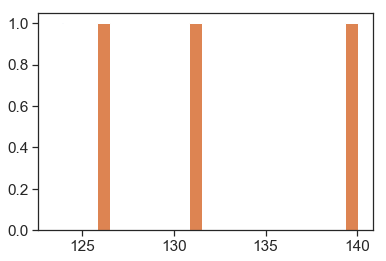

In [23]:
# Histogram of Left and Right decision time
datatablesL=datatables[0].loc[datatables[0]['decision']==1]
datatablesR=datatables[0].loc[datatables[0]['decision']==0]
#d1=datatables.decision
rtL=datatablesL.decisionduration
d=[]
for val in rtL: 
        if val != None: 
            d.append(val) 
plt.hist(d,20)
rtR=datatablesR.decisionduration
d=[]
for val in rtR: 
        if val != None: 
            d.append(val) 
plt.hist(d,20)

In [31]:
datatables[0].decisionduration

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward,msd_FSI_0,msd_LIPI_0,...,isr_GPeP_0_0,isr_GPeP_1_0,isr_D1STR_0_0,isr_D1STR_1_0,isr_D2STR_0_0,isr_D2STR_1_0,isr_LIP_0_0,isr_LIP_1_0,isr_Th_0_0,isr_Th_1_0
trial,,,,,,,,,,,,,,,,,,,,,
0,0,600.000000,737.026550,137.026550,437.026550,1037.026550,0,1,52.309166,0.0,...,42.057102,43.176201,0.024001,0.053337,0.030669,0.026668,15.379365,1.985415,3.269531,3.469543
1,1,1337.026550,1474.933960,137.907410,437.907410,1774.933960,0,0,49.980663,0.0,...,42.871796,43.011974,0.033326,0.017330,0.053320,0.053322,1.891757,15.232079,3.126005,3.297966
2,0,2074.933960,2195.758057,120.824097,420.824097,2495.758057,0,1,52.363674,0.0,...,41.061790,41.428699,0.066639,0.013327,0.026655,0.073303,14.967281,1.783568,3.078716,2.858804
3,0,2795.758057,2925.579834,129.821777,429.821777,3225.579834,0,1,55.179508,0.0,...,41.781197,41.871777,0.022656,0.059975,0.053310,0.035987,15.459762,1.896273,3.413250,3.594508
4,0,3525.579834,3648.403320,122.823486,422.823486,3948.403320,0,1,53.387691,0.0,...,41.028767,41.459484,0.113283,0.053311,-0.000002,0.033321,15.024604,1.896267,3.738439,3.647813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,142259.656250,142394.968750,135.312500,435.312500,142694.968750,1,0,56.021206,0.0,...,42.312828,42.564133,0.024329,0.094683,0.013513,0.060850,16.239408,2.099057,3.716536,3.769248
196,0,142994.968750,143115.046875,120.078125,420.078125,143415.046875,1,0,57.626019,0.0,...,40.939903,41.260147,0.067623,0.052741,0.067629,0.054084,15.831010,1.979580,3.633885,3.683897
197,1,143715.046875,143842.234375,127.187500,427.187500,144142.234375,1,1,52.752628,0.0,...,41.534813,41.982273,0.039210,0.017564,0.067630,0.013496,1.905042,15.389046,3.352552,3.632543


(0, 100)

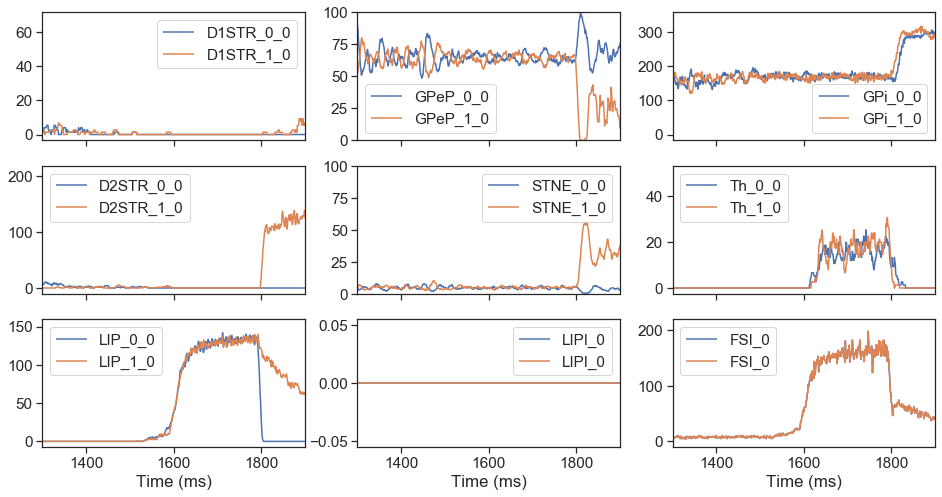

In [138]:
# Plot Population firing rates
results = ng.readAllTrialResults(8,0,sweepcount,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs'])
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1[0])
    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax1[1])
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[0])
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax3[2])

for ax, axx, axxx in zip(ax1, ax2, ax3):
#    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
#    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
#    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

    ax.set_xlim(1300,1900)
    axx.set_xlim(1300,1900)#
    axxx.set_xlim(1300,1900)#



ax2[1].set_ylim(0,100)
ax1[1].set_ylim(0,100)

plt.savefig('FR_ramping-NN.png', dpi=400)

In [35]:
#for col in datatables[0].columns.values:
#    print(col)

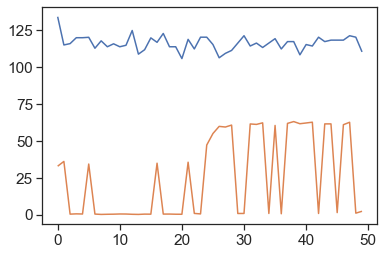

In [58]:
#x=datatables[0].decisiontime.to_string(index=False)
#print(x)
msr=datatables[0].msr_D1STR_1_0[0:50]
dt=datatables[0].decisiontime[0:50]
stt=datatables[0].stimulusstarttime[0:50]
#print(dt)
#y=list(dt)
#y2=list(stt)
plt.plot(dt-stt)
plt.plot(msr)